In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.manifold import TSNE
from itertools import chain
import time
import datetime
import pickle

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

import warnings
warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>

In [2]:
def graph_to_matrix(G,weighted=False,directed=False): # convert a graph object into a matrix
    matrix = np.zeros((len(G.nodes()),len(G.nodes())))
    for edge in G.edges(data=True):
        if weighted:
            matrix[edge[0],edge[1]] = edge[2]['weight']
        else:
            matrix[edge[0],edge[1]] = 1
        if not directed:
            matrix[edge[1],edge[0]] = matrix[edge[0],edge[1]] 
    return matrix
    
def matrix_to_graph(matrix): # convert an adjacency matrix into a graph object
    G = nx.Graph().to_directed()
    for i in range(matrix.shape[0]):
        G.add_node(i)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i,j] != 0:
                G.add_edge(i, j, weight=matrix[i,j])
    return G

def ErdosRenyiGraph(n,p):
    return nx.erdos_renyi_graph(n, p).to_directed(),False

def dRegularGraph(n,d):
    return nx.random_regular_graph(d, n).to_directed(),False

def randomAdjacencyMatrix(n,p,weighted=False,directed=False): #ErdosRenyi is unweighted & undirected
    # matrix is in dimension nxn (i.e. n is the number of nodes)
    # p is probability for having non-zero entries
    # values of non-zero entries are sampled in Unif[0,1) if graph is weighted
    matrix = (np.random.rand(n, n) < p).astype(int)
    np.fill_diagonal(matrix, 0)
    if weighted:
        matrix = matrix * np.random.rand(n, n)
    if not directed:
        for i in range(n):
            for j in range(n):
                matrix[j,i] = matrix[i,j]
    return matrix,directed

def geometricAdjacencyMatrix(n,d,r,metric='euclidean'):
    '''
    Valid values for metric are:
    From scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]. These metrics support sparse matrix inputs. [‘nan_euclidean’] but it does not yet support sparse matrices.
    From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] See the documentation for scipy.spatial.distance for details on these metrics. These metrics do not support sparse matrix inputs.
    '''
    points = np.random.uniform(0, 1, size=(n, d))
    distance_matrix = (pairwise_distances(points, metric=metric) < r).astype(int)
    np.fill_diagonal(distance_matrix, 0)
    return distance_matrix,False

def ChungLuGraph(n,max_degree):
    degrees = np.random.choice(range(1,max_degree+1), n, replace=True)
    G = nx.Graph()
    for node, degree in enumerate(degrees):
        G.add_node(node, degree=degree)
    for u in G.nodes():
        for v in G.nodes():
            if u < v and np.random.rand() < G.nodes[u]['degree'] * G.nodes[v]['degree'] / (2 * sum(degrees)):
                    G.add_edge(u, v)
    return G.to_directed(),False

def gridGraph(nrows,ncols): # not random
    G = nx.Graph()
    for i in range(nrows):
        for j in range(ncols):
            G.add_node(i*ncols+j)
    for i in range(nrows):
        for j in range(ncols):
            if i < nrows - 1:
                G.add_edge(i*ncols+j, (i+1)*ncols+j)
            if j < ncols - 1:
                G.add_edge(i*ncols+j+1, i*ncols+j)
    return G.to_directed(),False

In [3]:
def closestSeed_networkx(G,u,S,return_path=False):
    closest_point = None
    smallest_distance = float('inf')
    shortest_path = []
    for s in S:
        path = nx.shortest_path(G, source=u, target=s, weight="weight")
        distance = sum(G[path[i]][path[i + 1]]["weight"] for i in range(len(path) - 1))
        if distance < smallest_distance:
            closest_point, smallest_distance, shortest_path = path[-1], distance, path            
    if not return_path:
        return closest_point, smallest_distance
    else:
        return closest_point, smallest_distance, shortest_path

#### Das Sarma & Bourgain ####

def closestSeedFromStartPoint(graph, start, target_set, return_path=False):
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    target_set = [x for x in target_set if x != start]
    if len(target_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque([(start, 0, [])])  # Initialize the queue with the starting vertex, its path, and the total weight
        storage = deque() # To store nodes removed from queue

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex not in target_set:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from 'start' to 'neighbor' in queue or storage with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))

            elif vertex in target_set:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed
    
    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def closestSeedToEndPoint(graph, target, start_set, return_path=False): 
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    start_set = [x for x in start_set if x != target]
    if len(start_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque()  # Initialize the queue with the starting vertex, its path, and the total weight
        for i in range(len(start_set)):
            queue.append((start_set[i], 0, []))
        storage = deque()

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex != target:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor not in start_set and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from a start node to 'neighbor' in queue with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))
                                
            else:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed

    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def offlineSample(G,u,node_to_sets=True):
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    if len(support) == 0:
        return set()
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if node_to_sets:
        closest_points = set([closestSeedFromStartPoint(G,u,S) for S in sample_sets])
    else:
        closest_points = set([closestSeedToEndPoint(G,u,S) for S in sample_sets])
    if (None,float('inf')) in closest_points:
        closest_points.remove((None,float('inf')))
    return closest_points,set(np.concatenate(sample_sets))

def offlineSketch(G,u,k,node_to_sets=True):
    closest_points,sample_sets = offlineSample(G,u,node_to_sets)
    for i in range(k):
        closest_points_new,sample_sets_new = offlineSample(G,u,node_to_sets)
        closest_points = closest_points.union(closest_points_new)
        sample_sets = sample_sets.union(sample_sets_new)
    return np.array(list(closest_points)),np.array(list(sample_sets))

def onlineShortestPath_Sarma(G,u,v,k,directed=False): ## upper bound
    if not directed:
        sketch_u,_ = offlineSketch(G,u,k)
        sketch_v,_ = offlineSketch(G,v,k)
    else:
        sketch_u,_ = offlineSketch(G,u,k)
    if sketch_u.shape[0] != 0 and sketch_v.shape[0] != 0:
        common_nodes = [w for w in sketch_u[:,0] if w in sketch_v[:,0]]
        while None in common_nodes:
            common_nodes.remove(None)
        min_dist = float('inf')
        for w in common_nodes:
            dist = sketch_u[sketch_u[:, 0] == w][0,1] + sketch_v[sketch_v[:, 0] == w][0,1]
            if dist < min_dist:
                min_dist = dist
        return min_dist
    else:
        return float('inf')

def onlineShortestPath_Bourgain(G,u,v,directed=False): ## lower bound
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if directed:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        d_S_u = [closestSeedToEndPoint(G,u,S)[1] for S in sample_sets]
        d_S_v = [closestSeedToEndPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        to_remove = [idx for idx,val in enumerate(list(zip(d_S_u,d_S_v))) if val[0] == float('inf') or val[1] == float('inf')]
        d_S_u = np.array([value for index, value in enumerate(d_S_u) if index not in to_remove])
        d_S_v = np.array([value for index, value in enumerate(d_S_v) if index not in to_remove])
        return max([0,np.max(d_S_v-d_S_u),np.max(d_u_S-d_v_S)])
    else:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        return np.max(np.abs(d_u_S-d_v_S))

def shortestDistance_allNodes_Sarma(G,u,k,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Sarma(G,u,v,k,directed)
    return distances

def shortestDistance_allNodes_Bourgain(G,u,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Bourgain(G,u,v,directed)
    return distances

def shortestDistance_allNodes_networkx(G,u):
    if isinstance(G, np.ndarray):
        G = matrix_to_graph(G)
    n_nodes = len(G.nodes())
    distances = np.zeros(n_nodes)
    for v in range(n_nodes):
        if u != v:
            if nx.has_path(G, u, v):
                distances[v] = nx.shortest_path_length(G, u, v)
            else:
                distances[v] = float('inf')       
    return distances

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, out_channels, sigmoid = False, reLU = False):
        super(MLP, self).__init__()
        #torch.manual_seed(12345)
        self.name = 'mlp'
        self.lin1 = Linear(in_channels, hidden_channels1)
        self.lin2 = Linear(hidden_channels1, hidden_channels2)
        self.lin3 = Linear(hidden_channels2, hidden_channels3)
        self.lin4 = Linear(hidden_channels3, out_channels)
        #self.lin5 = Linear(hidden_channels4, hidden_channels5)
        #self.lin6 = Linear(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None
        if reLU:
            self.reLU = torch.nn.ReLU()
        else:
            self.reLU = None

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin5(x)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin6(x)
        if self.sigmoid != None:
            x = self.sigmoid(x)
        if self.reLU != None:
            x = self.reLU(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, out_channels, sigmoid = False, reLU = False):
        super(GCN, self).__init__()
        #torch.manual_seed(1234567)
        self.name = 'gcn'
        self.conv1 = GCNConv(in_channels, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.conv4 = GCNConv(hidden_channels3, out_channels)
        #self.conv5 = GCNConv(hidden_channels4, hidden_channels5)
        #self.conv6 = GCNConv(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv5(x, edge_index)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv6(x, edge_index)
        if self.sigmoid == None:
            return x
        else:
            return self.sigmoid(x)

def build(n, model_type,criterion_type,optimizer_type,scheduler_type=None):
    if model_type == 'mlp':
        if criterion_type == 'bce':
            model = MLP(n,12,8,4,2,sigmoid = True)
        elif criterion_type in ['mse','l2','l1']: 
            model = MLP(n,12,8,4,1,reLU = True)
        else:
            model = MLP(n,12,8,4,2)
    elif model_type == 'gcn':
        if criterion_type == 'bce':
            model = GCN(n,12,8,4,2,sigmoid = True)
        elif criterion_type in ['mse','l2','l1']: 
            model = GCN(n,12,8,4,1,reLU = True)
        else:
            model = GCN(n,12,8,4,2)
    else:
        raise ValueError(
            "Model type not yet defined."
        )
    
    if criterion_type == 'ce':
        criterion = torch.nn.CrossEntropyLoss()
    elif criterion_type == 'bce':
        criterion = torch.nn.BCELoss()
    elif criterion_type in ['mse','l2']:
        criterion = torch.nn.MSELoss()
    elif criterion_type == 'l1':
        criterion = torch.nn.L1Loss()
    else:
        raise ValueError(
            "Criterion type not yet defined."
        )
    
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
    elif optimizer_type == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.0001, alpha=0.99, eps=1e-8, momentum=0.9)
    elif optimizer_type == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.0001, lr_decay=0.0001)
    else:
        raise ValueError(
            "Optimizer type not yet defined."
        )
    
    if scheduler_type == None:
        scheduler = None
    else:
        if scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        elif scheduler_type == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)
        elif scheduler_type == 'exponential':
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        elif scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        elif scheduler_type == 'cyclic':
            if optimizer_type in ['sgd','rmsprop']:
                scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, cycle_momentum=True)
            else:
                scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, cycle_momentum=False)
        elif scheduler_type == 'cyclic-cosine':
            cycle_epochs = 5
            if optimizer_type in ['sgd','rmsprop']:
                scheduler_cyclic = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=cycle_epochs, cycle_momentum=True)
            else:
                scheduler_cyclic = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=cycle_epochs, cycle_momentum=False)
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cycle_epochs * 2)
        else:
            raise ValueError(
                "Scheduler type not yet defined."
            )
        
    print(model)
    if scheduler_type == 'cyclic-cosine':
        return model,criterion,optimizer,[scheduler_cyclic,scheduler_cosine]
    else:
        return model,criterion,optimizer,[scheduler]

In [5]:
def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index=None):
    t_loss = 0
    total_samples = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:0')
                    y = y.to('cuda:0')
                out = model(x)  # Perform a single forward pass.
                if criterion_type == 'bce':
                    y = torch.stack((1-y, y)).T.to(torch.float32)
                    y_true.extend(y[:,1])
                else:
                    y_true.extend(y)
                t_loss += criterion(out, y)
                total_samples += 1
                pred = out.argmax(dim=1) #  Use the class with highest probability.
                y_pred.extend(pred)
        else:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:0')
                    y = y.to('cuda:0')
                    edge_index = edge_index.to('cuda:0')
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type == 'bce':
                    y = torch.stack((1-y, y)).T.to(torch.float32)
                    y_true.extend(y[:,1])
                else:
                    y_true.extend(y)
                t_loss += criterion(out, y)
                total_samples += 1
                pred = out.argmax(dim=1) #  Use the class with highest probability.
                y_pred.extend(pred)
    t_loss = t_loss/total_samples
    t_loss = t_loss.cpu()
    y_true = [y.cpu() for y in y_true]
    y_pred = [y.cpu() for y in y_pred]
    if criterion_type in ['mse','l2']:
        return t_loss, np.mean((np.array(y_true) - np.array(y_pred)) ** 2), None, None
    elif criterion_type == 'l1':
        return t_loss, np.mean(np.abs(np.array(y_true) - np.array(y_pred))), None, None
    else:
        t_accuracy = sum(np.array(y_true) == np.array(y_pred))/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:0')
                y = y.to('cuda:0')
            out = model(x)  # Perform a single forward pass.
            if criterion_type == 'bce':
                y = torch.stack((1-y, y)).T.to(torch.float32)
            t_loss = criterion(out, y)  # Compute the loss solely based on the training nodes.
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:0')
                y = y.to('cuda:0')
                edge_index = edge_index.to('cuda:0')
            out = model(x,edge_index)  # Perform a single forward pass.
            if criterion_type == 'bce':
                y = torch.stack((1-y, y)).T.to(torch.float32)
            t_loss = criterion(out, y)  # Compute the loss solely based on the training nodes.
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy_or_error, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train)
    v_loss, v_accuracy_or_error, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()

    return train_loss,train_accuracy_or_error,train_sensitivity,train_specificity,v_loss,v_accuracy_or_error,v_sensitivity,v_specificity

def visualizeTNSE(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="")
    plt.show()

def run(samples,model_type,criterion_type,optimizer_type,scheduler_type,num_epochs,early_stopping_patience=None,visualize = False,save_model = False):   

    gpu_bool = torch.cuda.is_available()

    x_train = samples[0]
    x_val = samples[1]
    x_test = samples[2]
    y_train = samples[3]
    y_val = samples[4]
    y_test = samples[5]
    edge_index_train = samples[6]
    edge_index_val = samples[7]
    edge_index_test = samples[8]
    model,criterion,optimizer,scheduler = build(x_train[0].shape[0], model_type,criterion_type,optimizer_type,scheduler_type)

    if gpu_bool:
        model = model.to('cuda:0')
        
    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    train_loss = []
    train_acc_or_error = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc_or_error = []
    val_sen = []
    val_spec = []

    if early_stopping_patience != None:
        early_stopping_patience = num_epochs
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement_count = 0

    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            t_loss,t_acc_or_error,t_sen,t_spec, v_loss, v_acc_or_error, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            t_loss,t_acc_or_error,t_sen,t_spec, v_loss, v_acc_or_error, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val)
        train_loss.append(t_loss)
        train_acc_or_error.append(t_acc_or_error)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc_or_error.append(v_acc_or_error)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2']:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training MSE: {t_acc_or_error:.4f}, Validation Loss: {v_loss:.4f}, Validation MSE: {v_acc_or_error:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training MAE: {t_acc_or_error:.4f}, Validation Loss: {v_loss:.4f}, Validation MAE: {v_acc_or_error:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc_or_error:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc_or_error:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

        if early_stopping_patience != None:
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                best_epoch = epoch
                no_improvement_count = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                break

    if early_stopping_patience != None:
        model.load_state_dict(torch.load('best_model.pth'))
        if gpu_bool:
            model = model.to('cuda:0')

    if model_type == 'mlp':
        test_loss, test_acc_or_error, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc_or_error, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test)
    
    if early_stopping_patience == None:
        if criterion_type in ['mse','l2']:
            print(f'Test Loss: {test_loss:03f}, Test MSE: {test_acc_or_error:03f}')
        elif criterion_type == 'l1':
            print(f'Test Loss: {test_loss:03f}, Test MAE: {test_acc_or_error:03f}')
        else:
            print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc_or_error:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
    else:
        if criterion_type in ['mse','l2']:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test MSE: {test_acc_or_error:03f}')
        elif criterion_type == 'l1':
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test MAE: {test_acc_or_error:03f}')
        else:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc_or_error:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    x = range(1, len(train_loss)+1)
    if criterion_type in ['mse','l2','l1']:
        plt.plot(x, train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.6)
        plt.plot(x, val_loss, color = '#ff7f0e', label = 'validation loss', alpha = 0.6)
        if criterion_type == 'l1':
            plt.plot(x, train_acc_or_error, color = '#2ca02c', label = 'training mae', alpha = 0.6)
            plt.plot(x, train_acc_or_error, color = '#d62728', label = 'validation mae', alpha = 0.6)
        else:
            plt.plot(x, train_acc_or_error, color = '#2ca02c', label = 'training mse', alpha = 0.6)
            plt.plot(x, train_acc_or_error, color = '#d62728', label = 'validation mse', alpha = 0.6)
        plt.xlabel("epoch")
        plt.ylabel("")
        plt.title("training results")
        plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))
        plt.show()
    else:
        plt.plot(x, train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.6)
        plt.plot(x, train_acc_or_error, color = '#ff7f0e', label = 'training accuracy', alpha = 0.6)
        plt.plot(x, train_sen, color = '#2ca02c', label = 'training sensitivity', alpha = 0.6)
        plt.plot(x, train_spec, color = '#d62728', label = 'training specificity', alpha = 0.6)
        plt.plot(x, val_loss, color = '#9467bd', label = 'validation loss', alpha = 0.6)
        plt.plot(x, val_acc_or_error, color = '#8c564b', label = 'validation accuracy', alpha = 0.6)
        plt.plot(x, val_sen, color = '#e377c2', label = 'validation sensitivity', alpha = 0.6)
        plt.plot(x, val_spec, color = '#7f7f7f', label = 'validation specificity', alpha = 0.6)
        plt.xlabel("epoch")
        plt.ylabel("")
        plt.title("training results")
        plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))
        plt.show()

    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    model = model.to('cpu')
    if save_model:
        current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        torch.save(model, f"model_{current_datetime}.pth")
    if criterion_type in ['mse','l2','l1']:
        if early_stopping_patience == None:
            return [model, train_acc_or_error[-1], val_acc_or_error[-1], test_acc_or_error]
        else:
            return [model, train_acc_or_error[best_epoch-1], val_acc_or_error[best_epoch-1], test_acc_or_error]
    else:
        if early_stopping_patience == None:
            return [model, train_acc_or_error[-1], train_sen[-1], train_spec[-1], val_acc_or_error[-1], val_sen[-1], val_spec[-1], test_acc_or_error, test_sen, test_spec]
        else:
            return [model, train_acc_or_error[best_epoch-1], train_sen[best_epoch-1], train_spec[best_epoch-1], val_acc_or_error[best_epoch-1], val_sen[best_epoch-1], val_spec[best_epoch-1], test_acc_or_error, test_sen, test_spec]

In [6]:
def predict(gpu_bool,model,samples_x,samples_edge_index=None):
    y_pred = np.zeros((len(samples_x),samples_x[0].shape[0]))
    if gpu_bool:
        model = model.to('cuda:0')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:0')
                else:
                    x = samples_x[i]
                out = model(x)  # Perform a single forward pass.
                y_pred[i] = out.argmax(dim=1).cpu() #  Use the class with highest probability.
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:0')
                    edge_index = samples_edge_index[i].to('cuda:0')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                out = model(x,edge_index)  # Perform a single forward pass.
                y_pred[i] = out.argmax(dim=1).cpu() #  Use the class with highest probability.
    model = model.to('cpu')
    return y_pred

def predict_allBatches(model,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict(gpu_bool, model, samples[0], samples[6])
    y_pred_val = predict(gpu_bool, model, samples[1], samples[7])
    y_pred_test = predict(gpu_bool, model, samples[2], samples[8])
    return y_pred_train,y_pred_val,y_pred_test

In [7]:
def evaluate_inner(x_samples,true_distances,y_actual,y_pred,title,classification=True):

    if classification:

        graph_size = true_distances.shape[1]

        ## Calculate the proportion of points selected from the sample.
        ratio1 = np.mean(y_pred,axis=1)

        ## Check if any disconnected node is in actual sketch.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        M = np.max(true_distances) * 10
        true_distances[true_distances == -1] = M
        y_actual = torch.stack(y_actual).detach().numpy()
        dump_actual = y_actual*true_distances
        n_dump_actual_equal_M = np.sum((dump_actual == M).astype(int),axis=1)
        ratio2 = n_dump_actual_equal_M/np.sum(y_actual,axis=1) ## nan means empty sketch
        #ratio2[np.isnan(ratio2)] = -1

        ## Check if any disconnected node is chosen.
        dump = y_pred*true_distances
        n_true_distances_equal_M = np.sum((true_distances == M).astype(int),axis=1)
        n_dump_equal_M = np.sum((dump == M).astype(int),axis=1)
        n_selected = np.sum(y_pred,axis=1)
        n_selected[n_selected == 0] = 0.0001
        ratio3 = n_dump_equal_M/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio3[np.isnan(ratio3)] = -1

        ## Seed node and neighbors -> 1. Others -> 0
        seed_or_neighbors = np.zeros_like(true_distances)
        _,seeds = np.where(true_distances == 0) ## number of seeds = number of samples because we selected one seed from each sample
        seed_disconnected = np.zeros(seed_or_neighbors.shape[0])
        for i in range(len(seeds)):
            seed = seeds[i]
            seed_or_neighbors[i] = x_samples[i].detach().numpy()[seed]
            seed_disconnected[i] = sum((seed_or_neighbors[i]>0).astype(int))>0
            seed_or_neighbors[i,seed] = 1
        seed_or_neighbors_selected = seed_or_neighbors*y_pred

        ## Is seed node not disconnected from the remaining?
        seed_disconnected = seed_disconnected.astype(int)

        ## Have seed node and its neighbors been chosen?
        ratio4 = np.sum(seed_or_neighbors_selected,axis=1)/np.sum(seed_or_neighbors,axis=1)

        ## How many of the chosen nodes are seed node and its neighbors?
        ratio5 = np.sum(seed_or_neighbors_selected,axis=1)/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio5[np.isnan(ratio5)] = -1

        ## Check if the chosen nodes are closer than random selection.
        sum_distance_selected = np.sum(dump,axis=1)
        term0 = np.mean(true_distances,axis=1)
        term0[term0 == 0] = 0.0001
        ratio6 = sum_distance_selected/n_selected/term0 ## nan means no nodes have been selected, ratio1 = 0
        #ratio6[np.isnan(ratio6)] = -1

        ## Same as ratio3 but excludes disconnected nodes with inf distance to the seed node.
        n_selected[n_selected == 0.0001] = 0
        term1 = n_selected-n_dump_equal_M
        term1[term1 == 0] = 0.0001
        term2 = np.sum(true_distances,axis=1)-n_true_distances_equal_M*M
        term2[term2 == 0] = 0.0001
        ratio7 = (sum_distance_selected-n_dump_equal_M*M)/term1/term2*(graph_size-n_true_distances_equal_M)
        #ratio7[np.isnan(ratio7)] = -1
        ## nan means no nodes have been selected (ratio1 = 0) or selected nodes are all disconnected from seed node (inf distance)

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(ratio1)), ratio1, color = '#1f77b4', label = 'ratio 1: size of selected community to size of sample ratio',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio2, color = '#ff7f0e', label = 'ratio 2: proportion of disconnected nodes in actual sketch',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio3, color = '#2ca02c', label = 'ratio 3: proportion of disconnected nodes in the chosen community',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio4, color = '#d62728', label = 'ratio 4: proportion of seed node and its neighbors that are selected',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio5, color = '#9467bd', label = 'ratio 5: proportion of selected nodes that are seed node or its neighbors',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio6, color = '#8c564b', label = 'ratio 6: mean distance of chosen nodes to seed node divided by mean distance of all nodes to seed node',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio7, color = '#e377c2', label = 'ratio 7: same as ratio 6 but excludes disconnected nodes',alpha = 0.6)
        plt.scatter(range(len(ratio1)), seed_disconnected, color = 'k', marker='x', label = 'is seed node not disconnected from the remaining nodes in graph? 1 = True, 0 = False',alpha = 0.6)
        plt.xlabel("sample index")
        plt.ylabel("")
        plt.title(title)
        plt.legend(loc = 'lower center',bbox_to_anchor=(0.48, -0.6))
        plt.show()

        true_distances[true_distances == M] = np.inf
        return [np.mean(ratio1),np.mean(ratio2),np.mean(ratio3),np.mean(ratio4),np.mean(ratio5),np.mean(ratio6),np.mean(ratio7)]
        
    else:
        
        ## Calculate prediction to true distance ratio.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        y_pred[y_pred == np.inf] = -1
        M = max(np.max(true_distances),np.max(y_pred))*10
        true_distances[true_distances == -1] = M
        true_distances[true_distances == 0] = 0.0001 ## to avoid ratio = x/0
        y_pred[y_pred == -1] = M
        ratio = (y_pred/true_distances).flatten()
        
        if len(np.unique(ratio)) == 1:
            print('Prediction to true distance ratio is '+str(ratio[0])+' for all samples in '+title+'.')
        else:
            plt.hist(ratio,density=False)
            plt.xlabel("prediction to true distance ratio")
            plt.ylabel("frequency")
            plt.title(title)
            plt.show()
            print('mean ratio = ',np.mean(ratio))

        true_distances[true_distances == M] = np.inf
        true_distances[true_distances == 0.0001] = 0
        y_pred[y_pred == M] = np.inf

        return [np.mean(ratio)]
    
def evaluate(model,samples,classification = True):
    y_pred_train,y_pred_val,y_pred_test = predict_allBatches(model,samples)
    stats = []
    stats.append(evaluate_inner(samples[0],samples[9],samples[3],y_pred_train,'training data',classification))
    stats.append(evaluate_inner(samples[1],samples[10],samples[4],y_pred_val,'validation data',classification))
    stats.append(evaluate_inner(samples[2],samples[11],samples[5],y_pred_test,'test data',classification))
    return np.array(stats)

### Revised

In [8]:
def generateSamples_shortestPath_inner(n_samples,max_n_samples_per_graph,function,*args,**kwargs): ## max_n_samples_per_graph <= n
    samples_x = []
    samples_y = []
    samples_edge_index = []
    object,directed = function(*args,**kwargs)
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    k = len(object.nodes())
    i = 0
    while i<n_samples:
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            selected_pairs = []
            while i<n_samples and j<max_n_samples_per_graph: 
                selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                nodes = list(np.random.choice(list(selected_component), size=2, replace=False))
                if nodes not in selected_pairs and [nodes[1],nodes[0]] not in selected_pairs: ## avoid the same nodes to be selected again
                    path = nx.shortest_path(object, nodes[0], nodes[1], weight="weight")
                    #print('Ground truth shortest path:',path)
                    samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                    samples_y.append(torch.tensor([int(node in path) for node in range(0,k)]).to(torch.int64))
                    samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                    i += 1
                j += 1
        else:
            object,directed = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index

def generateSamples_shortestPath(n_train,n_val,n_test,max_n_samples_per_graph,function,*args,**kwargs):
    x_train, y_train, edge_index_train = generateSamples_shortestPath_inner(n_train,max_n_samples_per_graph,function,*args,**kwargs)
    x_val, y_val, edge_index_val = generateSamples_shortestPath_inner(n_val,max_n_samples_per_graph,function,*args,**kwargs)
    x_test, y_test, edge_index_test = generateSamples_shortestPath_inner(n_test,max_n_samples_per_graph,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test]

In [9]:
def generateSamples_sketch_classification_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y = []
    samples_edge_index = []
    object,directed = function(*args,**kwargs)
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    k = len(object.nodes())
    true_distances = np.zeros((n_samples,k))
    i = 0
    while i<n_samples:
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            while i<n_samples and j<max_n_samples_per_graph:
                n_err = 0
                while True:
                    try:
                        selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                        node = np.random.choice(list(selected_component))
                        sketch,sample_sets = offlineSketch(matrix_type,node,k)
                        if sketch.shape[0] != 0:
                            true_distances[i] = shortestDistance_allNodes_networkx(object,node)
                            #samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                            samples_x.append(torch.tensor(np.diag(np.array([int(node in sample_sets) for node in range(0,k)])).astype(np.float32), requires_grad=True))
                            sketch = np.append(sketch[:,0],node)
                            samples_y.append(torch.tensor([int(node in sketch) for node in range(0,k)]).to(torch.int64))
                            samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                            i += 1
                        j += 1
                        break
                    except:
                        n_err += 1
                        if n_err == 100:
                            j = max_n_samples_per_graph
                            break
                            # if i == 0:
                            #     raise ValueError(
                            #         "Did not succesfully generate any sample."
                            #     )
                            # else:
                            #     raise ValueError(
                            #         "Took too long to generate the full set of samples."
                            #     )
                        continue
        else:
            object,directed = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index, true_distances

def generateSamples_sketch_classification(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y_train, edge_index_train, true_distances_train = generateSamples_sketch_classification_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y_val, edge_index_val, true_distances_val = generateSamples_sketch_classification_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y_test, edge_index_test,true_distances_test = generateSamples_sketch_classification_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,true_distances_train,true_distances_val,true_distances_test]

In [10]:
def generateSamples_sketch_regression_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y = []
    samples_edge_index = []
    object,directed = function(*args,**kwargs)
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    k = len(object.nodes())
    true_distances = np.zeros((n_samples,k))
    i = 0
    while i<n_samples:
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            while i<n_samples and j<max_n_samples_per_graph:
                n_err = 0
                while True:
                    try:
                        selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                        node = np.random.choice(list(selected_component))
                        sketch,sample_sets = offlineSketch(matrix_type,node,k)
                        if sketch.shape[0] != 0:
                            true_distances[i] = shortestDistance_allNodes_networkx(object,node)
                            #samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                            samples_x.append(torch.tensor(np.diag(np.array([int(node in sample_sets) for node in range(0,k)])).astype(np.float32), requires_grad=True))
                            y = np.zeros(k)
                            for n in range(sketch.shape[0]):
                                y[int(sketch[n,0])] = sketch[n,1]
                            samples_y.append(torch.tensor(y).to(torch.float32))
                            samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                            i += 1
                        j += 1
                        break
                    except:
                        n_err += 1
                        if n_err == 100:
                            j = max_n_samples_per_graph
                            break
                            # if i == 0:
                            #     raise ValueError(
                            #         "Did not succesfully generate any sample."
                            #     )
                            # else:
                            #     raise ValueError(
                            #         "Took too long to generate the full set of samples."
                            #     )
                        continue  
        else:
            object,directed = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index, true_distances

def generateSamples_sketch_regression(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y_train, edge_index_train, true_distances_train= generateSamples_sketch_regression_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y_val, edge_index_val, true_distances_val = generateSamples_sketch_regression_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y_test, edge_index_test, true_distances_test = generateSamples_sketch_regression_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,true_distances_train,true_distances_val,true_distances_test]

15 1.0 1 1 bce
0.9593453407287598
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.1396, Training Accuracy: 0.9333, Training Sensitivity: 1.0000, Training Specificity: 0.9231, Validation Loss: 1.0692, Validation Accuracy: 0.7147, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.1329, Training Accuracy: 0.9333, Training Sensitivity: 0.5000, Training Specificity: 1.0000, Validation Loss: 1.2993, Validation Accuracy: 0.7147, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 030, Training Loss: 0.1308, Training Accuracy: 0.9333, Training Sensitivity: 0.5000, Training Specificity: 1.0000, Validation Loss: 1.4288, Validation Accuracy: 0.7147, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 040, Training Loss: 0.1204, Training Accuracy: 0.9333, Training Sensitivity: 1.0000, Training Specificity: 0.

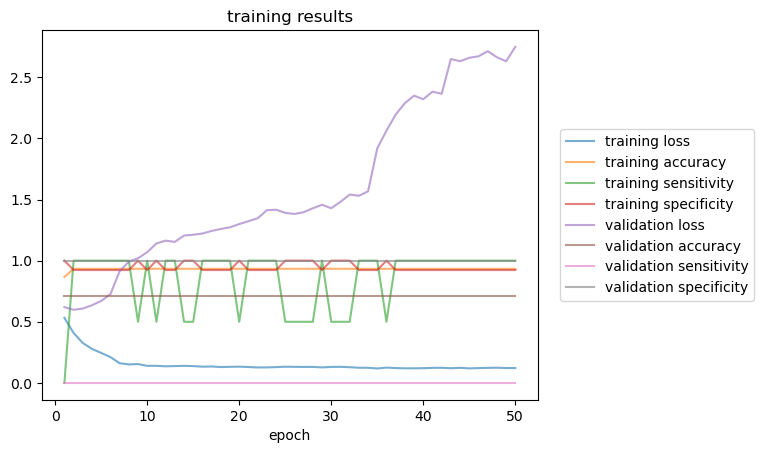

15 1.4906778224671577 1 1 bce


In [11]:
n_train = 500
n_val = 50
n_test = 50
n_epochs = 50
early_stopping_patience = None
t = 10
for max_n_samples_per_graph in [1,3,5]:
    for k in [1,3,5,7,9]:
        for n in [15,20,25,30,35,40,45,50,55,60]:
            results = []
            lamb = np.linspace(1,np.log(n)*2,t)
            for i in range(t):
                print(n,lamb[i], k, max_n_samples_per_graph, 'bce')
                t1 = time.time()
                samples = generateSamples_sketch_classification(n_train,n_val,n_test,max_n_samples_per_graph,k,ErdosRenyiGraph,n,lamb[i]/n)
                t2 = time.time()
                print(t2-t1)
                outputs = run(samples,'gcn','bce','adam','cyclic-cosine',n_epochs,early_stopping_patience)
                results.append(outputs[1:])
            with open('ERresults_sketch_n'+str(n)+'_k'+str(k)+'_'+str(max_n_samples_per_graph)+'.pkl', 'wb') as file:
                pickle.dump(np.array(results), file)

15 1.0 1 1 bce
1.122631549835205
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.1196, Training Accuracy: 0.9333, Training Sensitivity: 1.0000, Training Specificity: 0.9231, Validation Loss: 1.6668, Validation Accuracy: 0.7853, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.1168, Training Accuracy: 0.9333, Training Sensitivity: 1.0000, Training Specificity: 0.9231, Validation Loss: 1.9267, Validation Accuracy: 0.7853, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Best Epoch: 001, Test Loss: 0.737005, Test Accuracy: 0.706667, Test Sensitivity: 0.000000, Test Specificity: 1.000000


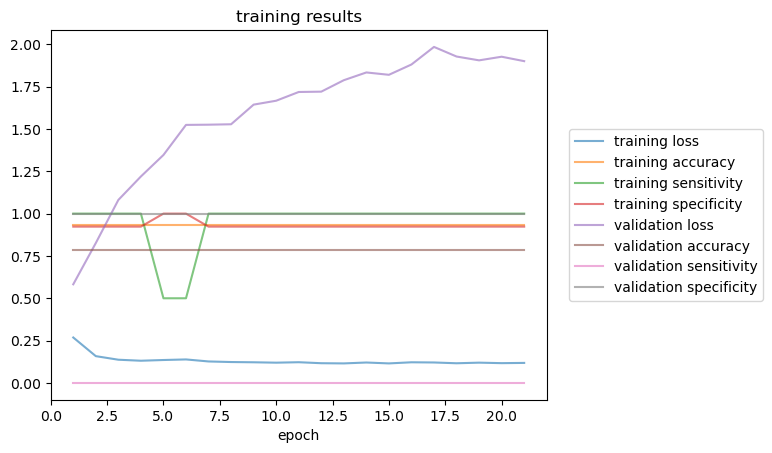

15 1.4906778224671577 1 1 bce
0.7901487350463867
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.1949, Training Accuracy: 0.9664, Training Sensitivity: 0.9563, Training Specificity: 0.9779, Validation Loss: 0.8200, Validation Accuracy: 0.5373, Validation Sensitivity: 0.1413, Validation Specificity: 0.9049
Epoch: 020, Training Loss: 0.1818, Training Accuracy: 0.9664, Training Sensitivity: 0.9563, Training Specificity: 0.9779, Validation Loss: 0.9153, Validation Accuracy: 0.5453, Validation Sensitivity: 0.1413, Validation Specificity: 0.9203
Best Epoch: 001, Test Loss: 0.592786, Test Accuracy: 0.750667, Test Sensitivity: 0.891791, Test Specificity: 0.672199


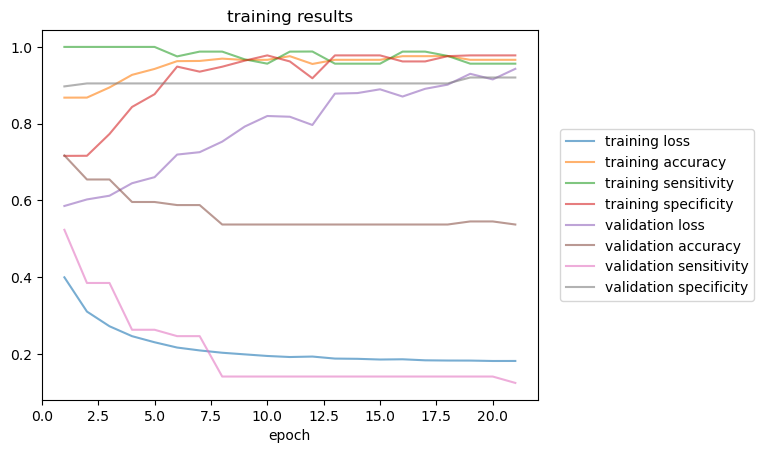

15 1.9813556449343155 1 1 bce
0.6901376247406006
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.4281, Training Accuracy: 0.7501, Training Sensitivity: 0.1349, Training Specificity: 0.9530, Validation Loss: 0.8900, Validation Accuracy: 0.5160, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.4004, Training Accuracy: 0.7737, Training Sensitivity: 0.2301, Training Specificity: 0.9530, Validation Loss: 0.9305, Validation Accuracy: 0.5160, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Best Epoch: 001, Test Loss: 0.701453, Test Accuracy: 0.506667, Test Sensitivity: 0.000000, Test Specificity: 1.000000


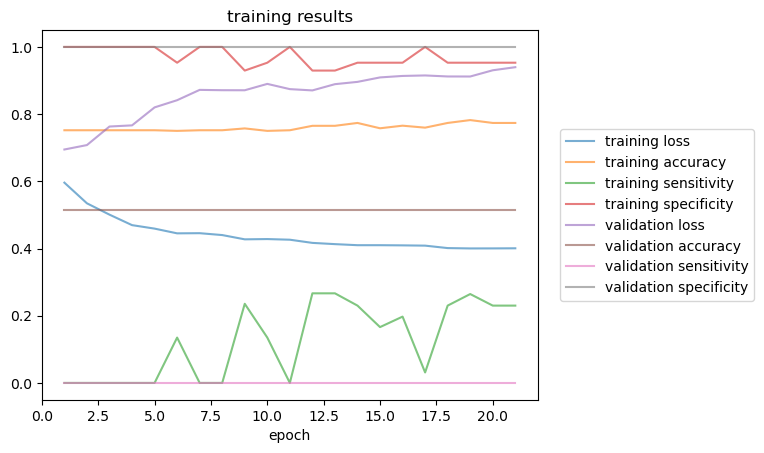

15 2.4720334674014737 1 1 bce
1.0072450637817383
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.4143, Training Accuracy: 0.8267, Training Sensitivity: 0.7515, Training Specificity: 0.9424, Validation Loss: 0.8362, Validation Accuracy: 0.6133, Validation Sensitivity: 0.4877, Validation Specificity: 0.7987
Epoch: 020, Training Loss: 0.3896, Training Accuracy: 0.8380, Training Sensitivity: 0.7515, Training Specificity: 0.9712, Validation Loss: 0.8694, Validation Accuracy: 0.6213, Validation Sensitivity: 0.4877, Validation Specificity: 0.8185
Best Epoch: 001, Test Loss: 0.538678, Test Accuracy: 0.856000, Test Sensitivity: 1.000000, Test Specificity: 0.000000


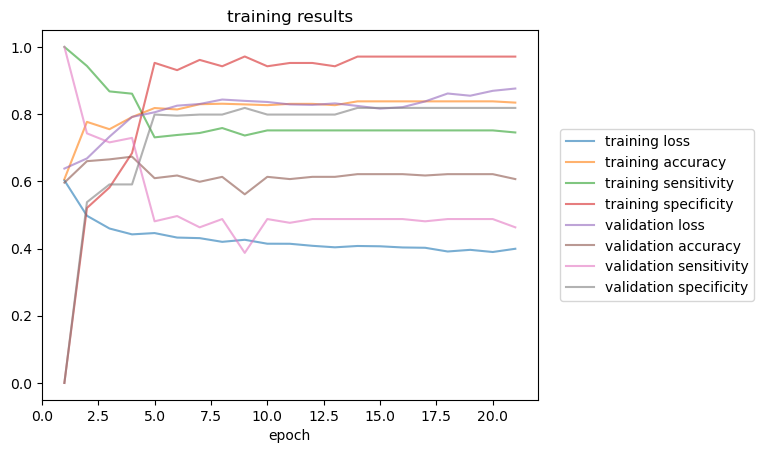

15 2.962711289868631 1 1 bce
1.340757131576538
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.3033, Training Accuracy: 0.9125, Training Sensitivity: 0.9949, Training Specificity: 0.3910, Validation Loss: 0.4161, Validation Accuracy: 0.7720, Validation Sensitivity: 1.0000, Validation Specificity: 0.0172
Epoch: 020, Training Loss: 0.3026, Training Accuracy: 0.9125, Training Sensitivity: 0.9949, Training Specificity: 0.3910, Validation Loss: 0.4175, Validation Accuracy: 0.7720, Validation Sensitivity: 1.0000, Validation Specificity: 0.0172
Epoch: 030, Training Loss: 0.3013, Training Accuracy: 0.9125, Training Sensitivity: 0.9949, Training Specificity: 0.3910, Validation Loss: 0.4180, Validation Accuracy: 0.8133, Validation Sensitivity: 0.9861, Validation Specificity: 0.2414
Best Epoch: 012, Test Loss: 0.484353, Test Accuracy: 0.825333, Test Sensitivity: 1.000000, Test Specifi

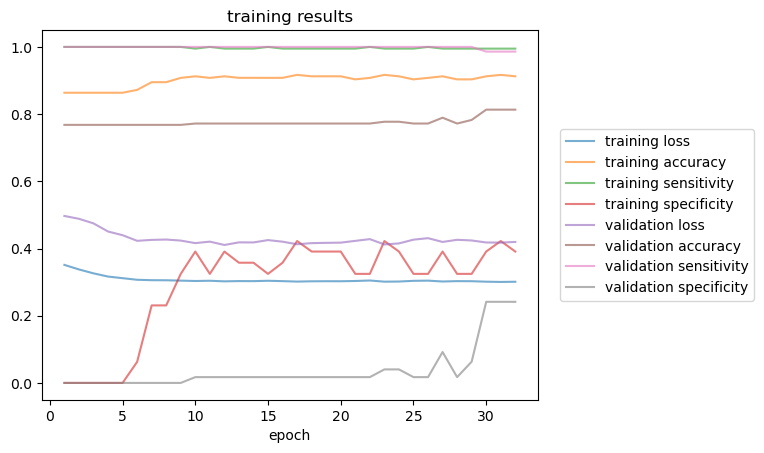

15 3.453389112335789 1 1 bce
1.3127036094665527
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2302, Training Accuracy: 0.9436, Training Sensitivity: 0.9940, Training Specificity: 0.7864, Validation Loss: 0.3771, Validation Accuracy: 0.8480, Validation Sensitivity: 1.0000, Validation Specificity: 0.3804
Epoch: 020, Training Loss: 0.2208, Training Accuracy: 0.9481, Training Sensitivity: 0.9940, Training Specificity: 0.8051, Validation Loss: 0.3924, Validation Accuracy: 0.8347, Validation Sensitivity: 0.9823, Validation Specificity: 0.3804
Best Epoch: 009, Test Loss: 0.429506, Test Accuracy: 0.780000, Test Sensitivity: 0.958167, Test Specificity: 0.419355


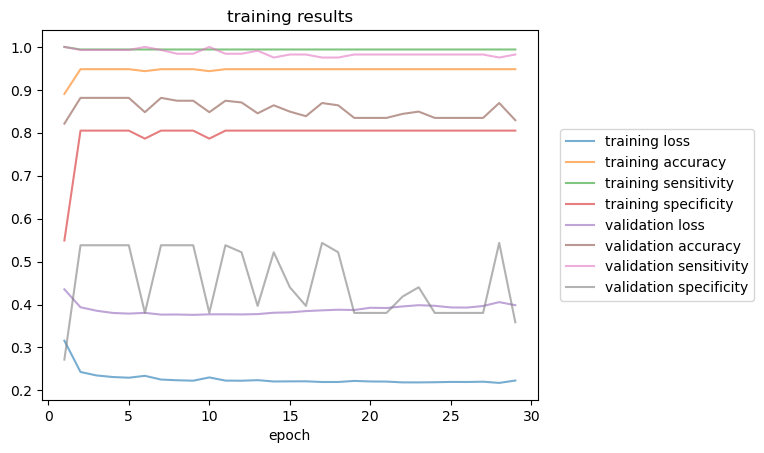

15 3.944066934802947 1 1 bce
1.3081824779510498
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.3231, Training Accuracy: 0.8633, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.3606, Validation Accuracy: 0.8933, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 020, Training Loss: 0.3097, Training Accuracy: 0.9185, Training Sensitivity: 0.9958, Training Specificity: 0.4302, Validation Loss: 0.3641, Validation Accuracy: 0.8933, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Best Epoch: 002, Test Loss: 0.348562, Test Accuracy: 0.876000, Test Sensitivity: 1.000000, Test Specificity: 0.000000


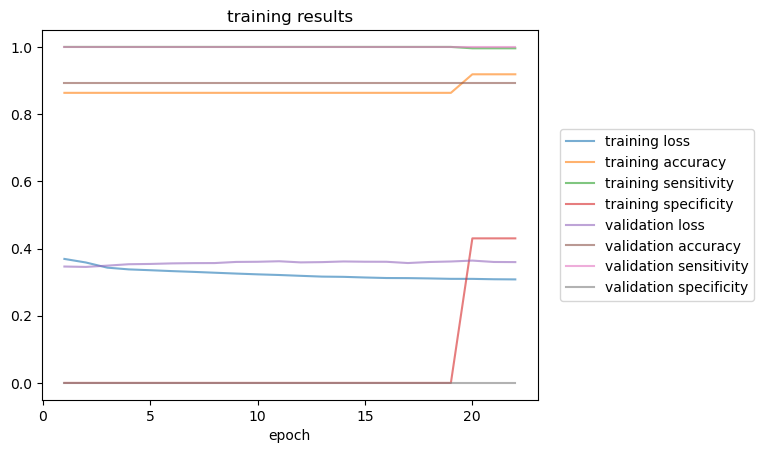

15 4.434744757270105 1 1 bce
1.278806209564209
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.3043, Training Accuracy: 0.9080, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.5652, Validation Accuracy: 0.7747, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 020, Training Loss: 0.2982, Training Accuracy: 0.9080, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.6405, Validation Accuracy: 0.7747, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Best Epoch: 001, Test Loss: 0.442351, Test Accuracy: 0.818667, Test Sensitivity: 1.000000, Test Specificity: 0.000000


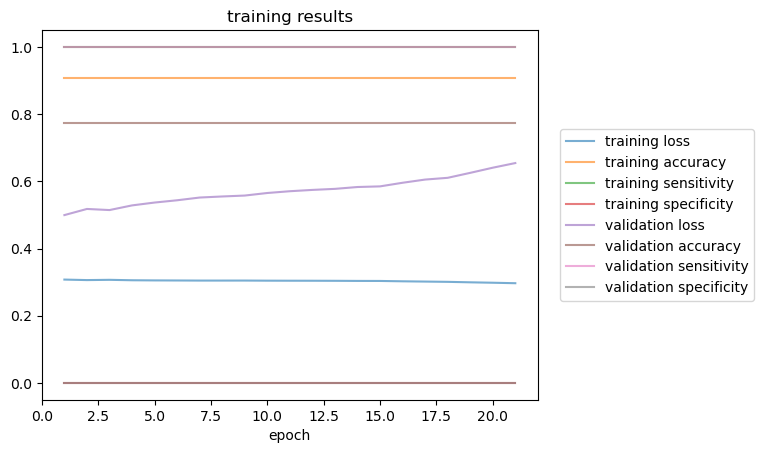

15 4.925422579737262 1 1 bce
1.8059639930725098
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2930, Training Accuracy: 0.9107, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.2734, Validation Accuracy: 0.9200, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 020, Training Loss: 0.2939, Training Accuracy: 0.9107, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.2758, Validation Accuracy: 0.9200, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Best Epoch: 001, Test Loss: 0.308928, Test Accuracy: 0.906667, Test Sensitivity: 1.000000, Test Specificity: 0.000000


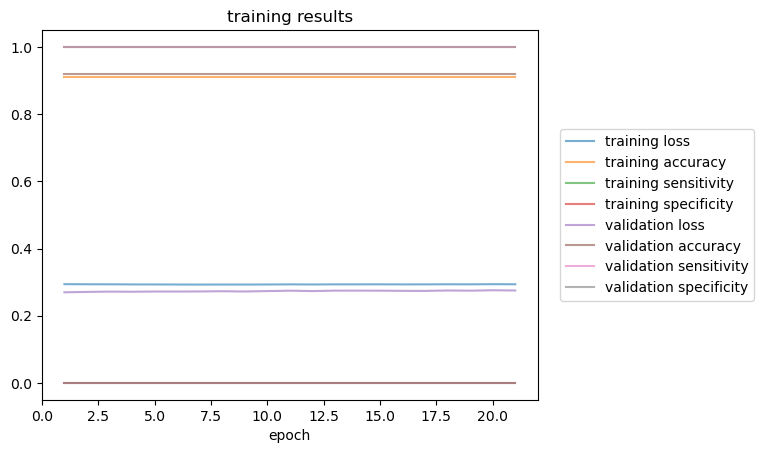

15 5.41610040220442 1 1 bce
1.9137153625488281
GCN(
  (conv1): GCNConv(15, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2929, Training Accuracy: 0.9107, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.3098, Validation Accuracy: 0.9040, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Epoch: 020, Training Loss: 0.2947, Training Accuracy: 0.9107, Training Sensitivity: 1.0000, Training Specificity: 0.0000, Validation Loss: 0.3110, Validation Accuracy: 0.9040, Validation Sensitivity: 1.0000, Validation Specificity: 0.0000
Best Epoch: 003, Test Loss: 0.272253, Test Accuracy: 0.921333, Test Sensitivity: 1.000000, Test Specificity: 0.000000


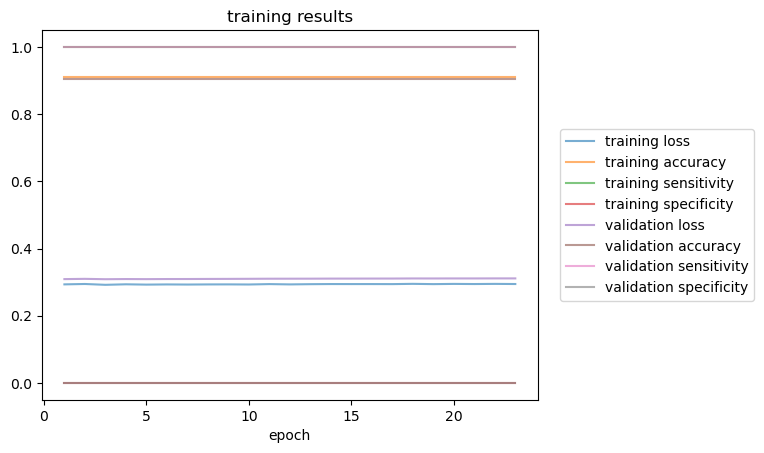

20 1.0 1 1 bce
1.0098228454589844
GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2575, Training Accuracy: 0.8619, Training Sensitivity: 0.5420, Training Specificity: 0.9567, Validation Loss: 0.2953, Validation Accuracy: 0.7750, Validation Sensitivity: 0.1346, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.2508, Training Accuracy: 0.9069, Training Sensitivity: 0.7388, Training Specificity: 0.9567, Validation Loss: 0.2708, Validation Accuracy: 0.8030, Validation Sensitivity: 0.3385, Validation Specificity: 0.9662
Epoch: 030, Training Loss: 0.2474, Training Accuracy: 0.9177, Training Sensitivity: 0.7861, Training Specificity: 0.9567, Validation Loss: 0.2583, Validation Accuracy: 0.7950, Validation Sensitivity: 0.3385, Validation Specificity: 0.9554
Epoch: 040, Training Loss: 0.2516, Training Accuracy: 0.9177, Training Sensitivity: 0.7861, Training Specificity: 0.

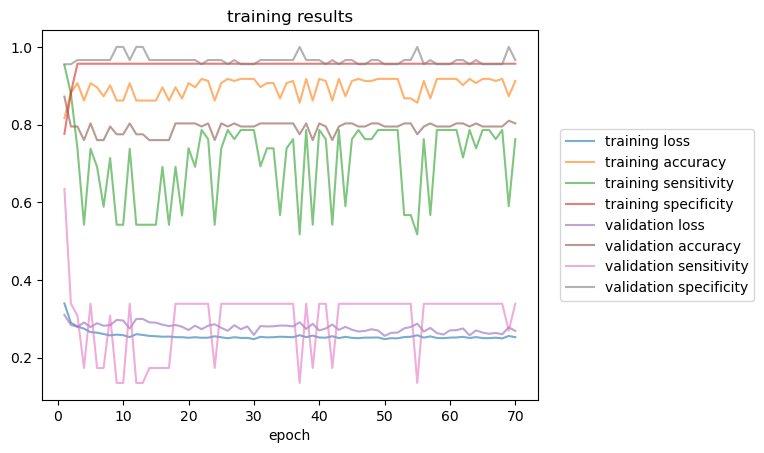

20 1.5546071719008867 1 1 bce
1.151252031326294
GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.4085, Training Accuracy: 0.7607, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.8669, Validation Accuracy: 0.5820, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Epoch: 020, Training Loss: 0.4052, Training Accuracy: 0.7607, Training Sensitivity: 0.0000, Training Specificity: 1.0000, Validation Loss: 0.9918, Validation Accuracy: 0.5820, Validation Sensitivity: 0.0000, Validation Specificity: 1.0000
Best Epoch: 001, Test Loss: 0.691426, Test Accuracy: 0.546000, Test Sensitivity: 0.000000, Test Specificity: 1.000000


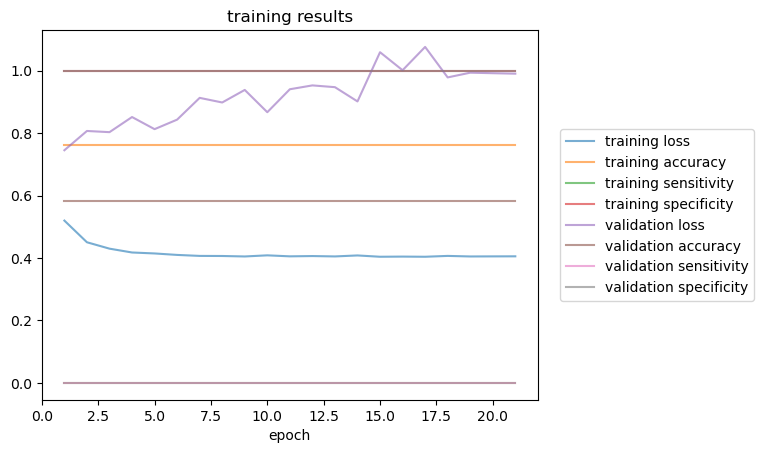

20 2.1092143438017734 1 1 bce
1.65230131149292
GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2793, Training Accuracy: 0.9413, Training Sensitivity: 0.9869, Training Specificity: 0.7998, Validation Loss: 0.3857, Validation Accuracy: 0.8240, Validation Sensitivity: 1.0000, Validation Specificity: 0.3623
Epoch: 020, Training Loss: 0.2752, Training Accuracy: 0.9382, Training Sensitivity: 0.9869, Training Specificity: 0.7871, Validation Loss: 0.3808, Validation Accuracy: 0.8240, Validation Sensitivity: 1.0000, Validation Specificity: 0.3623
Epoch: 030, Training Loss: 0.2715, Training Accuracy: 0.9413, Training Sensitivity: 0.9869, Training Specificity: 0.7998, Validation Loss: 0.3781, Validation Accuracy: 0.8240, Validation Sensitivity: 1.0000, Validation Specificity: 0.3623
Epoch: 040, Training Loss: 0.2704, Training Accuracy: 0.9413, Training Sensitivity: 0.9869, Training Sp

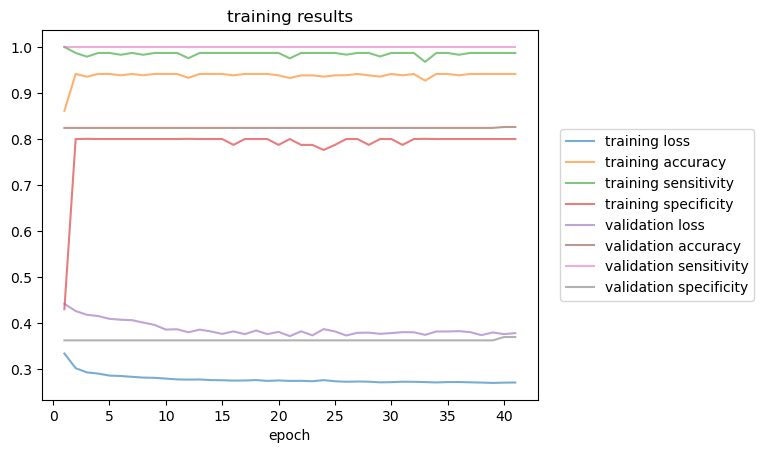

20 2.6638215157026606 1 1 bce
1.7521846294403076
GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)
Epoch: 010, Training Loss: 0.2928, Training Accuracy: 0.9158, Training Sensitivity: 0.9889, Training Specificity: 0.7280, Validation Loss: 0.4729, Validation Accuracy: 0.7320, Validation Sensitivity: 0.5606, Validation Specificity: 0.9054
Epoch: 020, Training Loss: 0.2692, Training Accuracy: 0.9432, Training Sensitivity: 0.9854, Training Specificity: 0.8347, Validation Loss: 0.4650, Validation Accuracy: 0.7360, Validation Sensitivity: 0.5686, Validation Specificity: 0.9054
Epoch: 030, Training Loss: 0.2634, Training Accuracy: 0.9432, Training Sensitivity: 0.9854, Training Specificity: 0.8347, Validation Loss: 0.4733, Validation Accuracy: 0.7360, Validation Sensitivity: 0.5686, Validation Specificity: 0.9054
Epoch: 040, Training Loss: 0.2606, Training Accuracy: 0.9432, Training Sensitivity: 0.9854, Training 

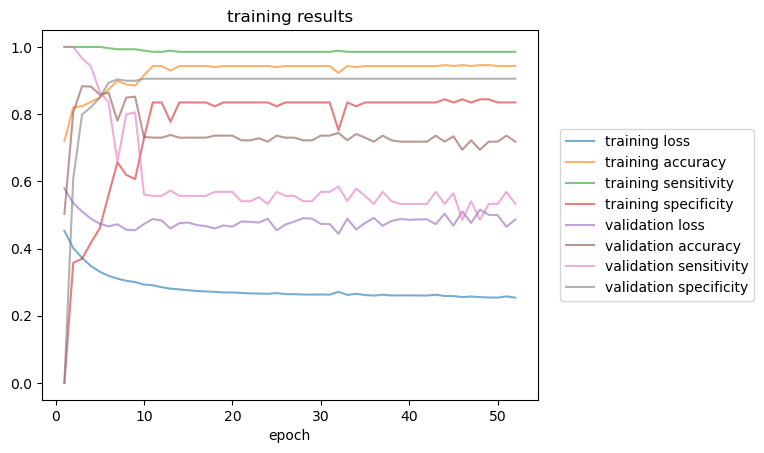

20 3.2184286876035473 1 1 bce
1.751302719116211
GCN(
  (conv1): GCNConv(20, 12)
  (conv2): GCNConv(12, 8)
  (conv3): GCNConv(8, 4)
  (conv4): GCNConv(4, 2)
  (sigmoid): Sigmoid()
)


KeyboardInterrupt: 

In [11]:
n_samples = 500
t = 10
for max_n_samples_per_graph in [1,3,5]:
    for k in [1,3,5,7,9]:
        for n in [15,20,25,30,35,40,45,50,55,60]:
            results = []
            lamb = np.linspace(1,np.log(n)*2,t)
            for i in range(t):
                print(n,lamb[i], k, max_n_samples_per_graph, 'bce')
                t1 = time.time()
                samples = generateSamples_sketch_classification(n_samples,50,50,max_n_samples_per_graph,k,ErdosRenyiGraph,n,lamb[i]/n)
                t2 = time.time()
                print(t2-t1)
                outputs = run(samples,'gcn','bce','adam','cyclic-cosine',100,20)
                results.append(outputs[1:])
            with open('ERresults_sketch_n'+str(n)+'_k'+str(k)+'_'+str(max_n_samples_per_graph)+'.pkl', 'wb') as file:
                pickle.dump(np.array(results), file)

In [ ]:
t = 5
for n_samples in [500]:
    for k in [1,3,5]:
        for n in [15,30,45,60]:
            results = []
            lamb = np.linspace(1,n/2,t)
            for i in range(t):
                print(n,lamb[i],'mse')
                t1 = time.time()
                samples = generateSamples_sketch_classification(n_samples,50,50,5,k,ErdosRenyiGraph,n,lamb[i]/n)
                t2 = time.time()
                print(t2-t1)
                outputs = run(samples,'gcn','mse','adam',None,100,20)
                results.append(outputs[1:])
            with open('ERresults_sketch_regression_n'+str(n)+'_k'+str(k)+'_'+str(n_samples)+'.pkl', 'wb') as file:
                pickle.dump(np.array(results), file)

In [ ]:
#with open('ERresults_sketch_n'+str(15)+'_k'+str(k)+'_'+str(n_samples)+'.pkl', 'rb') as file:
    #results = pickle.load(file)
#results

array([[GCN(
          (conv1): GCNConv(15, 12)
          (conv2): GCNConv(12, 8)
          (conv3): GCNConv(8, 4)
          (conv4): GCNConv(4, 2)
          (sigmoid): Sigmoid()
        )                         , 0.9448, 1.0, 0.928509756518736,
        0.784, 0.44, 0.8369230769230769, 0.9333333333333333, 0.5, 1.0],
       [GCN(
          (conv1): GCNConv(15, 12)
          (conv2): GCNConv(12, 8)
          (conv3): GCNConv(8, 4)
          (conv4): GCNConv(4, 2)
          (sigmoid): Sigmoid()
        )                         , 0.9112, 1.0, 0.0, 0.9066666666666666,
        1.0, 0.0, 0.908, 1.0, 0.0]], dtype=object)